In [3]:
import geopandas as gpd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as colormaps
from matplotlib.contour import ContourSet
import re

In [5]:
regiones = gpd.read_file(r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\hidrogeologia\hydrogeol_provs_rapid_invPolygon.shp')
print(regiones.columns)

Index(['REPORT_LIN', 'INVENTORYN', 'PROVINCE_N', 'MAJOR_AQUI', 'HYDROGEOLO',
       'GROUNDWATE', 'SALINITY_5', 'SALINITY_9', 'SWL_5TH_PE', 'SWL_95TH_P',
       'IMPORTANT_', 'NATIVE_TIT', 'SUMMARY', 'MAIN_POPUL', 'GEOLOGICAL',
       'GEOLOGICA0', 'GEOLOGICA1', 'TOTAL_AREA', 'ONSHORE_AR', 'TOPO_FEATU',
       'geometry'],
      dtype='object')


In [9]:
npfile = np.load(r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NSW\fit\nswfit_DTW.npz')
print(npfile.files)

['dtw_syr', 'dtw_condyr', 'dtw_s_nmax_yr', 'dtw_nmax_yr', 'dtw_vyr', 'dtw_tyr', 'dtw_resyr', 'HydroID', 'lat', 'lon', 'dtw_interc_f', 'dtw_slop_f']


In [11]:
dtw_syr       = npfile.f.dtw_syr
dtw_condyr    = npfile.f.dtw_condyr
dtw_s_nmax_yr = npfile.f.dtw_s_nmax_yr
dtw_nmax_yr   = npfile.f.dtw_nmax_yr
dtw_tyr       = npfile.f.dtw_tyr
dtw_vyr       = npfile.f.dtw_vyr
dtw_resyr     = npfile.f.dtw_resyr
HydroID       = npfile.f.HydroID
lat           = npfile.f.lat
lon           = npfile.f.lon
dtw_interc_f  = npfile.f.dtw_interc_f
dtw_slop_f    = npfile.f.dtw_slop_f

C:\Users\afandinop\AppData\Local\Temp\ipykernel_22680\2177939055.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = colormaps.get_cmap('Pastel1')


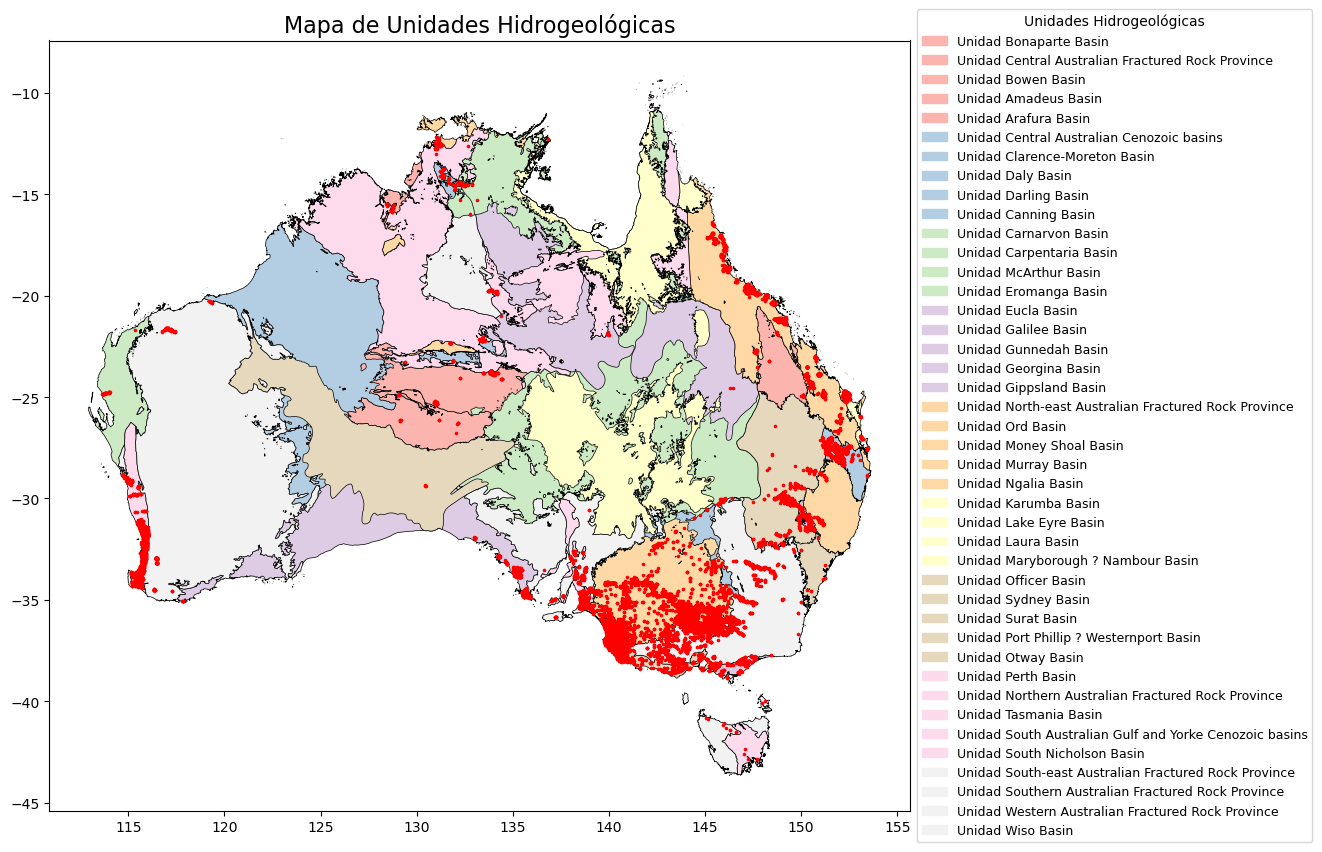

In [13]:
def vis_pozos(shp_path, npz_paths):
  
    mapa = gpd.read_file(shp_path)
    all_lon = []
    all_lat = []

    # Procesar cada archivo .npz
    for npz_path in npz_paths:
        pozos = np.load(npz_path)
        mask = pozos['dtw_condyr'] == 1
        all_lon.append(pozos['lon'][mask])
        all_lat.append(pozos['lat'][mask])

    lon = np.concatenate(all_lon)
    lat = np.concatenate(all_lat)

    # Generar colores para las regiones
    unique_regions = mapa['PROVINCE_N'].unique()
    cmap = colormaps.get_cmap('Pastel1')  
    region_colors = {region: cmap(i / len(unique_regions)) for i, region in enumerate(unique_regions)}  # Asignar colores

    fig, ax = plt.subplots(figsize=(15, 10))
    for region, color in region_colors.items():
        mapa[mapa['PROVINCE_N'] == region].plot(ax=ax, color=color, edgecolor='black', linewidth=0.5)

    ax.scatter(lon, lat, color='red', marker='.', s=10, label='Pozos')
    ax.set_title('Mapa de Unidades Hidrogeológicas', fontsize=16)
    region_patches = [mpatches.Patch(color=color, label=f'Unidad {region}') for region, color in region_colors.items()]
    ax.legend(handles=region_patches, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9, title="Unidades Hidrogeológicas")
    plt.subplots_adjust(right=0.8)
    plt.show()

shp_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\hidrogeologia\hydrogeol_provs_rapid_invPolygon.shp'
npz_path = [r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NSW\fit\nswfit_DTW.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NT\fit\ntfit_DTW.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_QLD\fit\qldfit_DTW.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_SA\fit\safit_DTW.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_TAS\fit\tasfit_DTW.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_VIC\fit\vicfit_DTW.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_WA\fit\wafit_DTW.npz']

vis_pozos(shp_path, npz_path)

In [37]:
def vis_pozos_por_region(shp_path, npz_paths, output_folder):
    # Cargar shapefile y verificar proyección
    mapa = gpd.read_file(shp_path)
    if mapa.crs is None:
        raise ValueError("El shapefile no tiene un sistema de coordenadas definido.")
    print(f"CRS del shapefile: {mapa.crs}")
    
    # Listas para almacenar coordenadas de todos los pozos
    all_lon = []
    all_lat = []

    # Procesar cada archivo .npz
    for npz_path in npz_paths:
        pozos = np.load(npz_path)
        if 'lon' not in pozos or 'lat' not in pozos or 'dtw_condyr' not in pozos:
            raise ValueError(f"El archivo {npz_path} no contiene las claves necesarias ('lon', 'lat', 'dtw_condyr').")
        
        # Filtrar pozos válidos
        mask = pozos['dtw_condyr'] == 1
        all_lon.append(pozos['lon'][mask])
        all_lat.append(pozos['lat'][mask])

    # Combinar todas las coordenadas de pozos
    lon = np.concatenate(all_lon)
    lat = np.concatenate(all_lat)

    # Crear un GeoDataFrame para los pozos
    pozos_gdf = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in zip(lon, lat)], crs="EPSG:4326")
    if pozos_gdf.crs != mapa.crs:
        pozos_gdf = pozos_gdf.to_crs(mapa.crs)

    # Intersección espacial para asignar pozos a regiones
    pozos_asignados = gpd.sjoin(pozos_gdf, mapa, how='inner', predicate='intersects')

    # Contar pozos por región
    pozos_por_region = pozos_asignados['PROVINCE_N'].value_counts()

    # Graficar un zoom por cada región con pozos
    for region, count in pozos_por_region.items():
        print(f'Región: {region}, Pozos: {count}')
        
        region_geom = mapa[mapa['PROVINCE_N'] == region]

    
        pozos_region = pozos_asignados[pozos_asignados['PROVINCE_N'] == region]

        fig, ax = plt.subplots(figsize=(10, 8))
        region_geom.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.5)
        pozos_region.plot(ax=ax, color='red', marker='.', markersize=10, label='Pozos')

        ax.set_title(f'Unidad: {region} (Pozos: {count})', fontsize=14)
        ax.legend()
        output_file = f"{output_folder}/DTWunidad_{re.sub(r'[^a-zA-Z0-9_]', '_', region)}.png"
        plt.savefig(output_file, bbox_inches='tight')
        plt.close()

# Rutas de los archivos
shp_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\hidrogeologia\hydrogeol_provs_rapid_invPolygon.shp'
npz_paths = [r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NSW\theilsen\nswtheilsen_DTW.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NT\theilsen\nttheilsen_DTW.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_QLD\theilsen\qldtheilsen_DTW.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_SA\theilsen\satheilsen_DTW.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_TAS\theilsen\tastheilsen_DTW.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_VIC\theilsen\victheilsen_DTW.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_WA\theilsen\watheilsen_DTW.npz'
    
]
output_folder = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\images'

# Llamar a la función
vis_pozos_por_region(shp_path, npz_paths, output_folder)

CRS del shapefile: EPSG:4326


NameError: name 'Point' is not defined

C:\Users\afandinop\AppData\Local\Temp\ipykernel_22680\4211952663.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = colormaps.get_cmap('Pastel1')


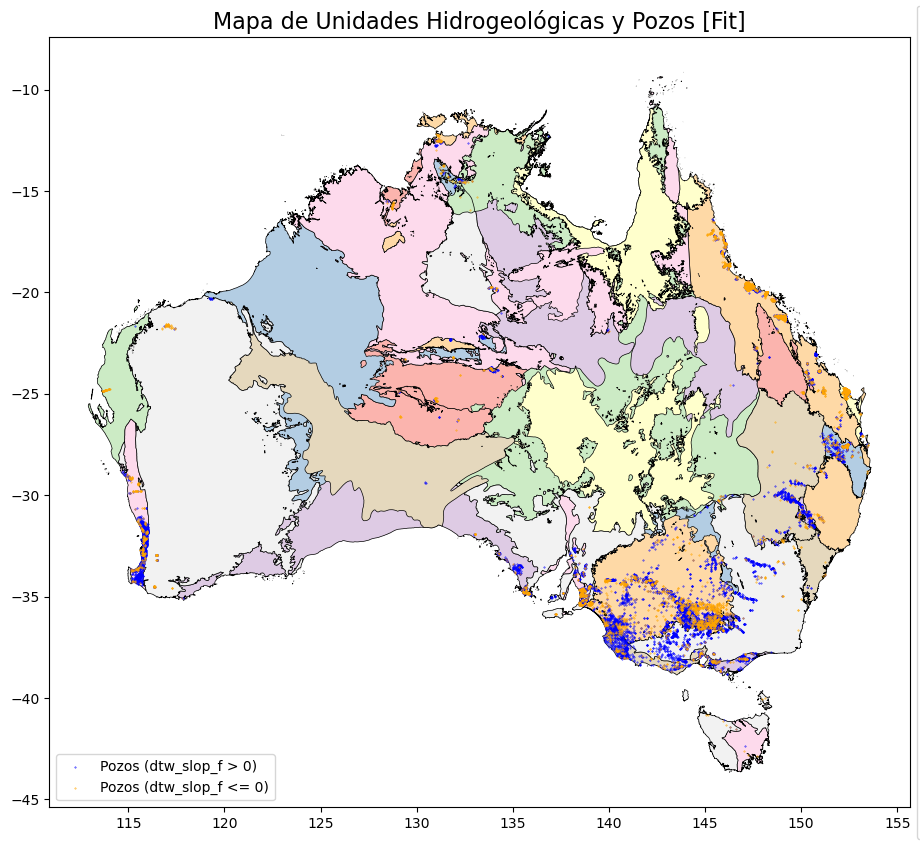

In [16]:
def vis_pozos(shp_path, npz_paths):
    
    mapa = gpd.read_file(shp_path)
    all_lon_pos = []
    all_lat_pos = []
    all_lon_neg = []
    all_lat_neg = []

    # Procesar cada archivo .npz
    for npz_path in npz_paths:
        pozos = np.load(npz_path)
        mask = pozos['dtw_condyr'] == 1
        lon = pozos['lon'][mask]
        lat = pozos['lat'][mask]
        slope = pozos['dtw_slop_f'][mask]  # Filtrar valores de la pendiente

        # Clasificar pozos por pendiente positiva o negativa
        pos_mask = slope > 0
        neg_mask = slope <= 0

        all_lon_pos.append(lon[pos_mask])
        all_lat_pos.append(lat[pos_mask])
        all_lon_neg.append(lon[neg_mask])
        all_lat_neg.append(lat[neg_mask])

    # Concatenar los valores para graficar
    lon_pos = np.concatenate(all_lon_pos)
    lat_pos = np.concatenate(all_lat_pos)
    lon_neg = np.concatenate(all_lon_neg)
    lat_neg = np.concatenate(all_lat_neg)

    # Generar colores para las regiones
    unique_regions = mapa['PROVINCE_N'].unique()
    cmap = colormaps.get_cmap('Pastel1')  
    region_colors = {region: cmap(i / len(unique_regions)) for i, region in enumerate(unique_regions)}  # Asignar colores

    fig, ax = plt.subplots(figsize=(15, 10))
    for region, color in region_colors.items():
        mapa[mapa['PROVINCE_N'] == region].plot(ax=ax, color=color, edgecolor='black', linewidth=0.5)

    # Graficar pozos
    ax.scatter(lon_pos, lat_pos, color='blue', marker='.', s=0.5, label='Pozos (dtw_slop_f > 0)')
    ax.scatter(lon_neg, lat_neg, color='orange', marker='.', s=0.5, label='Pozos (dtw_slop_f <= 0)')

    # Títulos y leyendas
    ax.set_title('Mapa de Unidades Hidrogeológicas y Pozos [Fit]', fontsize=16)
    region_patches = [mpatches.Patch(color=color, label=f'Unidad {region}') for region, color in region_colors.items()]
    legend_pozos = ax.legend(handles=region_patches, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9, title="Unidades Hidrogeológicas")
    ax.legend(loc='lower left', fontsize=10)
    ax.add_artist(legend_pozos)
    plt.subplots_adjust(right=0.8)
    plt.show()

# Rutas de entrada
shp_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\hidrogeologia\hydrogeol_provs_rapid_invPolygon.shp'
npz_paths = [
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NSW\fit\nswfit_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NT\fit\ntfit_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_QLD\fit\qldfit_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_SA\fit\safit_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_TAS\fit\tasfit_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_VIC\fit\vicfit_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_WA\fit\wafit_DTW.npz'
]

# Llamada a la función
vis_pozos(shp_path, npz_paths)
output_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\hydrogeologyDTW_fit.png'